# Developing an AI application

In this project, I train an image classifier to recognize different species of flowers. I'll use [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.
The project is broken down into multiple steps:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Load the datasets with ImageFolder
dirs = {'train':train_dir,
        'valid': valid_dir,
        'test': test_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}


# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True) for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

In [27]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:17<00:00, 33364946.61it/s]


In [6]:
input_size = 25088
hidden_sizes = [4096, 1024]
output_size = 102

hidden_layer_sizes = zip(hidden_sizes[:-1], hidden_sizes[1:])

layers_map = [('fc1', nn.Linear(input_size, hidden_sizes[0])),
                    ('relu1', nn.ReLU()),
                    ('dropout1', nn.Dropout(0.2))]
count = 1
for h1, h2 in hidden_layer_sizes:
    count +=1
    layers_map.append(('fc'+str(count), nn.Linear(h1,h2)))
    layers_map.append(('relu'+str(count), nn.ReLU()))
    layers_map.append(('dropout'+str(count), nn.Dropout(0.2)))
layers_map.append(('fc'+str(count+1), nn.Linear(hidden_sizes[-1], output_size)))
layers_map.append(('output', nn.LogSoftmax(dim=1)))
classifier = nn.Sequential(OrderedDict(layers_map))

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = classifier

 I got the training function mostly from the [Pytorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and Josh Berhnhard's [tutorial](https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad) here

In [7]:
def train_model(model, criterion, optimizer, scheduler,    
                                      num_epochs=30, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
criteria = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

eps=10

In [10]:
model = model.cuda() #transferring the model on to the GPU
model_ft = train_model(model, criteria, optimizer, sched, eps, 'cuda')

Epoch 0/9
----------
train Loss: 2.5329 Acc: 0.3788
valid Loss: 1.1510 Acc: 0.6748

Epoch 1/9
----------
train Loss: 1.3273 Acc: 0.6392
valid Loss: 0.9536 Acc: 0.7396

Epoch 2/9
----------
train Loss: 1.0161 Acc: 0.7286
valid Loss: 0.6677 Acc: 0.8191

Epoch 3/9
----------
train Loss: 0.9279 Acc: 0.7425
valid Loss: 0.7670 Acc: 0.7653

Epoch 4/9
----------
train Loss: 0.6258 Acc: 0.8214
valid Loss: 0.4703 Acc: 0.8741

Epoch 5/9
----------
train Loss: 0.5421 Acc: 0.8481
valid Loss: 0.4338 Acc: 0.8888

Epoch 6/9
----------
train Loss: 0.5162 Acc: 0.8536
valid Loss: 0.4210 Acc: 0.8888

Epoch 7/9
----------
train Loss: 0.4781 Acc: 0.8648
valid Loss: 0.4043 Acc: 0.8973

Epoch 8/9
----------
train Loss: 0.4441 Acc: 0.8744
valid Loss: 0.3998 Acc: 0.8973

Epoch 9/9
----------
train Loss: 0.4388 Acc: 0.8796
valid Loss: 0.3956 Acc: 0.8998

Training complete in 39m 18s
Best val Acc: 0.899756


In [9]:
def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device='cuda')  
    final = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            equals = predicted == labels.data
            print(equals.float().mean())

In [20]:
calc_accuracy(model_ft, 'test', cuda=True)

tensor(0.6875, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.750

In [21]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19',
            'state_dict': model_ft.state_dict(), 
            'class_to_idx': model_ft.class_to_idx}, 
            'classifier.pth')

In [10]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'vgg19':
        model = models.vgg19(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
        sys.exit()
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 1024)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [11]:
model = load_model('classifier.pth')
calc_accuracy(model, 'test', True)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [15]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    from PIL import Image
    
    # Load the image
    img = Image.open(image)
    
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img
    
    # TODO: Process a PIL image for use in a PyTorch model

In [16]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

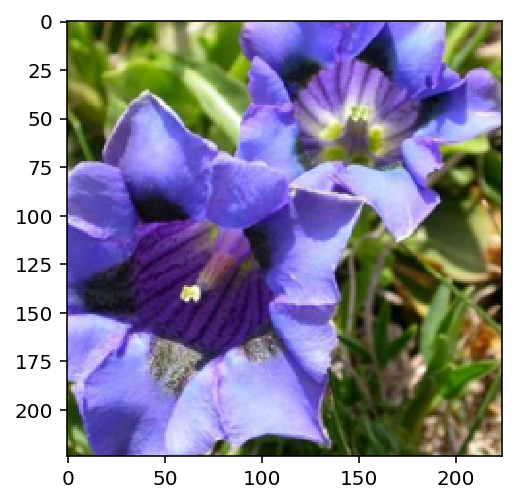

In [17]:
image_path = 'flowers/test/28/image_05230.jpg'
img = process_image(image_path)
imshow(img)

In [23]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [53]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax);
    plt.title(title_)
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

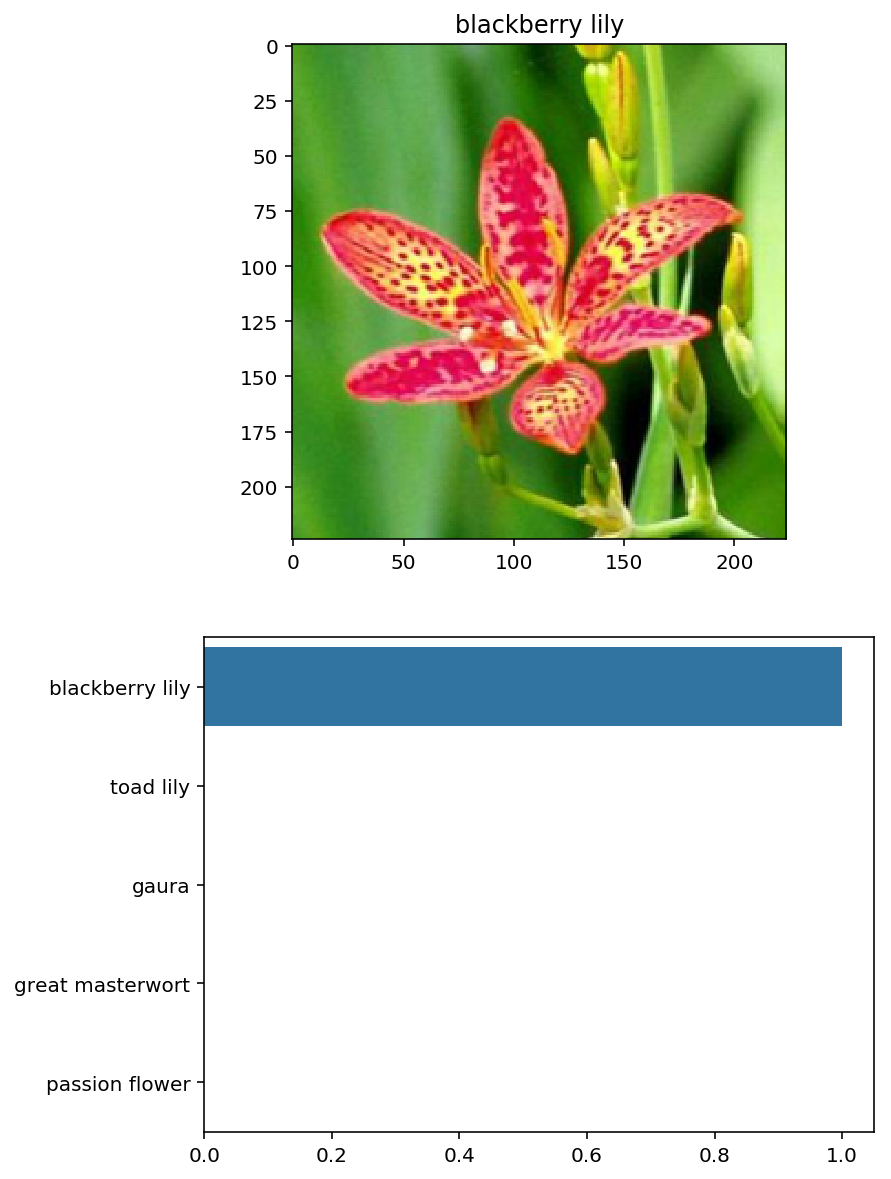

In [54]:
image_path = 'flowers/test/102/image_08023.jpg'
plot_solution(image_path, model)

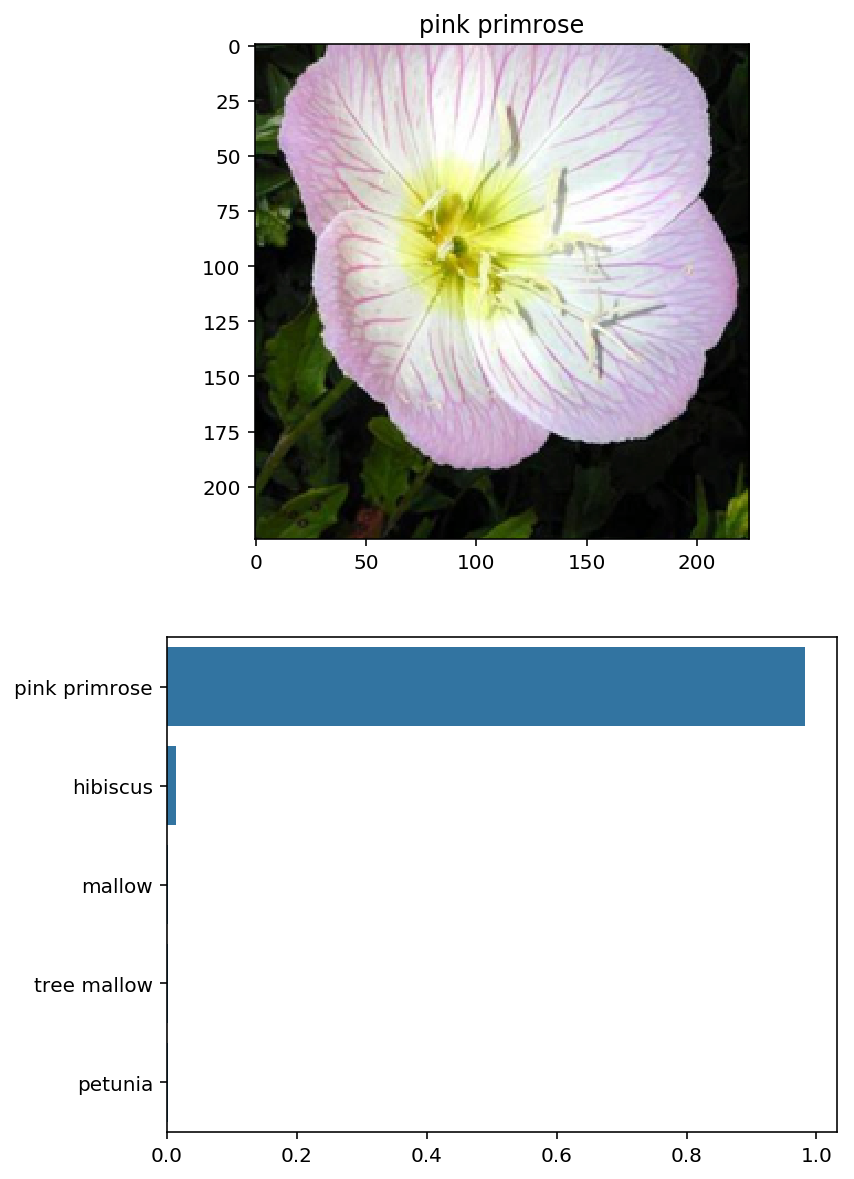

In [46]:
image_path = 'flowers/test/1/image_06743.jpg'
plot_solution(image_path, model)